In [1]:
import numpy as np
from scipy.linalg import norm
from scipy.sparse.linalg import expm_multiply, expm
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import SparsePauliOp, Operator, Statevector

# Exercise
We have seen how to time evolve an Ising Hamiltonian. In this exercise we ask you to time-evolve a Heisenberg Hamiltonian with transverse field,
$$ H = J \sum_i X_i X_{i+1} + Y_i Y_{i+1} + Z_i Z_{i+1} + h \sum_i X_i$$
for $N=4$ sites with $J = 1, h = 0.5$, periodic boundary conditions (PBC).
1. Modify the `get_H_op` function suitably to print out all the Pauli terms of the hamiltonian.
    - How many are there for a 4 site model with periodic boundary conditions (PBC).
2. Implement a method `heisenberg_trotter_circ` to obtain the circuit for Trotter evolution. (This should be the equivalent function to `ising_trotter_circ` from the tutorial.)
    - Print the Trotter circuit for 1 Trotter step with a steps size of $\delta t = 0.25$.
3. Compare the exact time evolution with your Trotter implementation up to $t = 10$ with a Trotter time step of $\delta t = 0.1$
    - compute the same observables as in the tutorial; the average magnetization $M_z = \frac{1}{N} \sum_i Z_i$ and the initial state revival $|\langle \psi_{\rm init} | \psi(t) \rangle|^2$.
    - plot both quantities as a function of time for both the exact and the Trotter evolution
    - print the final value (at time $t = 10$) of magnetization and initial state revival for exact and Trotter evolution.

# Solution
### 1. Modify the `get_H_op` function suitably to print out all the Pauli terms of the hamiltonian.
- How many are there for a 4 site model with periodic boundary conditions (PBC)?

In [1]:
def get_H_op(N, Jx, Jy, Jz, h, pbc):
    """Define the non-commuting parts of the Hamiltonian separately."""

    zz_ops = []
    yy_ops = []
    xx_ops = []
    x_ops = []

    for i in range(N - 1):
        zz_ops.append((N - 2 - i) * "I" + "ZZ" + i * "I")
        yy_ops.append((N - 2 - i) * "I" + "YY" + i * "I")
        xx_ops.append((N - 2 - i) * "I" + "XX" + i * "I")
        x_ops.append((N - 1 - i) * "I" + "X" + i * "I")

    x_ops.append("X" + (N - 1) * "I")

    # Add periodic boundary conditions
    if pbc and N > 2:
        zz_ops.append("Z" + (N - 2) * "I" + "Z")
        yy_ops.append("Y" + (N - 2) * "I" + "Y")
        xx_ops.append("X" + (N - 2) * "I" + "X")

    zz_ops = SparsePauliOp(data=zz_ops, coeffs=[Jx] * (N if (pbc and N > 2) else N - 1))
    yy_ops = SparsePauliOp(data=yy_ops, coeffs=[Jy] * (N if (pbc and N > 2) else N - 1))
    xx_ops = SparsePauliOp(data=xx_ops, coeffs=[Jz] * (N if (pbc and N > 2) else N - 1))
    x_ops = SparsePauliOp(data=x_ops, coeffs=[h] * N)

    return xx_ops, yy_ops, zz_ops, x_ops

### 2. Implement a method `heisenberg_trotter_circ` to obtain the circuit for Trotter evolution.
- Print the Trotter circuit for 1 Trotter step with a steps size of $\delta t = 0.25$.


In [3]:
def heisenberg_trotter_circ(H_list, N, t_final, dt, init_circ=None):
    """This method implements a Trotter circuit for the time evolution of the transverse field Ising model."""
    Nt = int(np.round(t_final / dt))

    # Fill here
    XX_ops = H_list[0]
    YY_ops = H_list[1]
    ZZ_ops = H_list[2]
    X_ops = H_list[3]

    XX_circ = QuantumCircuit(N)
    YY_circ = QuantumCircuit(N)
    ZZ_circ = QuantumCircuit(N)
    X_circ = QuantumCircuit(N)

    # XX terms
    for i, coeff in enumerate(XX_ops.coeffs):
        # indices of qubits acted on by Rxx gate, keeping in mind periodic boundaty conditions
        if not i == N - 1:
            n, m = i, i + 1
        else:
            n, m = N - 1, 0

        XX_circ.h(n)
        XX_circ.h(m)
        XX_circ.cx(n, m)
        XX_circ.rz(2 * float(coeff) * dt, m)
        XX_circ.cx(n, m)
        XX_circ.h(n)
        XX_circ.h(m)

    # YY terms, I was not sure how to do this, unsure about the K gate
    for i, coeff in enumerate(YY_ops.coeffs):
        # indices of qubits acted on by Ryy gate, keeping in mind periodic boundaty conditions
        if not i == N - 1:
            n, m = i, i + 1
        else:
            n, m = N - 1, 0

        YY_circ.sdg(n)
        YY_circ.sdg(m)
        YY_circ.h(n)
        YY_circ.h(m)
        YY_circ.cx(n, m)
        YY_circ.rz(2 * float(coeff) * dt, m)
        YY_circ.cx(n, m)
        YY_circ.h(n)
        YY_circ.h(m)
        YY_circ.s(n)
        YY_circ.s(m)

    # ZZ terms
    for i, coeff in enumerate(ZZ_ops.coeffs):
        # indices of qubits acted on by Rzz gate, keeping in mind periodic boundaty conditions
        if not i == N - 1:
            n, m = i, i + 1
        else:
            n, m = N - 1, 0

        ZZ_circ.cx(n, m)
        ZZ_circ.rz(2 * float(coeff) * dt, m)
        ZZ_circ.cx(n, m)

    # X terms
    for i, coeff in enumerate(X_ops.coeffs):
        # need to account for the factor of 2 again
        X_circ.rx(2 * float(coeff) * dt, i)
    
    qreg = QuantumRegister(N)
    evo_circ = QuantumCircuit(qreg)

    # Fill here
    if init_circ is not None:
        evo_circ.append(init_circ, qreg)
    for _ in range(Nt):
        evo_circ.append(XX_circ, qreg)
        evo_circ.append(YY_circ, qreg)
        evo_circ.append(ZZ_circ, qreg)
        evo_circ.append(X_circ, qreg)
        evo_circ.barrier()
        
        
    return evo_circ



### 3. Compare the exact time evolution with your Trotter implementation up to t = ?
- compute the same observables as in the tutorial; the average magnetization $M_z = \frac{1}{N} \sum_i Z_i$ and the initial state revival $|\langle \psi_{\rm init} | \psi(t) \rangle|^2$.
- plot both quantities as a function of time for both the exact and the Trotter evolution
- print the final value (at time $t = 10$) of magnetization and initial state revival for exact and Trotter evolution.

In [4]:
def init_state(N):
    init_circ = QuantumCircuit(N)
    return init_circ

def exact_evo(N, H, t_eval, obs):
    # get initial state
    psi_init = Statevector(init_state(N)).data
    # intitialize array to store expectation values at every time step
    expect_vals = []
    init_state_revival = []
    # loop through time values up to final time
    for t in t_eval:
        # evolve statevector for each time step.
        # NOTE: this is exact since we have access to the exponential of the FULL Hamiltonain matrix
        # and do not need to decompose into exponentials of individual summands
        psi = expm_multiply(-1j * t * H, psi_init)
        # compute expectation value at every time step
        # NOTE: we have the full statevector here, so we can evaluate the expectation value exactly
        # by simple matrix-vector-multiplication
        expect_vals.append(np.real(np.conj(psi).dot(obs).dot(psi)))
        overlap = np.conj(psi_init).dot(psi)
        init_state_revival.append(overlap.real**2 + overlap.imag**2)

    return expect_vals, init_state_revival

Define observable $M_z = \frac{1}{N} \sum_i Z_i$

In [5]:
N = 4
Jx = 1
Jy = Jx
Jz = Jy

XX_ops, YY_ops, ZZ_ops, X_ops = get_H_op(N, Jx, Jy, Jz, 0, True)
H_op = XX_ops + YY_ops + ZZ_ops + X_ops

mag_ave = SparsePauliOp(data=[((N - 1 - i)*"I" + "Z" + i*"I")
                        for i in range(N)], coeffs=[1 / N] * N)
print(f"M_average =\n{mag_ave}")

mag_ave = mag_ave.to_matrix()

M_average =
SparsePauliOp(['IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j])


Exact evolution

In [6]:
t_final = 10 * np.abs(Jz)
dt = 0.01
Nt = int(t_final / dt)
t_eval = np.linspace(0, t_final, Nt + 1)

exact_mag, init_state_revival = exact_evo(N, H_op.to_matrix(sparse=True), t_eval, mag_ave)

Trotter evolution

In [13]:
init_circ = QuantumCircuit(N)
psi_init = Statevector(init_circ).data

t_final = 10 * np.abs(Jx)
dt = 0.2
Nt = int(t_final / dt)
t_eval_trotter = np.linspace(0, t_final, Nt + 1)

trotter_circ_res = []
trotter_circ_init_state_rev = []
trotter_circ_mag = []
for t in t_eval_trotter:
    circ = heisenberg_trotter_circ([XX_ops, YY_ops, ZZ_ops, X_ops], N, t, dt, init_circ)
    trotter_circ_mag.append(np.real(np.conj(psi_init).dot(mag_ave).dot(psi_init)))
    psi = Statevector(circ).data

    trotter_circ_res.append(np.real(np.conj(psi).dot(mag_ave).dot(psi)))
    overlap = np.conj(psi_init).dot(psi)
    trotter_circ_init_state_rev.append(overlap.real**2 + overlap.imag**2)
    
print(f"Final magnetization exact: {exact_mag[-1]}")
print(f"Final magnetization Trotter: {trotter_circ_mag[-1]}")
print(f"Final initial state overlap exact: {init_state_revival[-1]}")
print(f"Final initial state overlap Trotter: {trotter_circ_init_state_rev[-1]}")

/tmp/ipykernel_397/2563012414.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  XX_circ.rz(2 * float(coeff) * dt, m)
/tmp/ipykernel_397/2563012414.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
  YY_circ.rz(2 * float(coeff) * dt, m)
/tmp/ipykernel_397/2563012414.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  ZZ_circ.rz(2 * float(coeff) * dt, m)
/tmp/ipykernel_397/2563012414.py:67: ComplexWarning: Casting complex values to real discards the imaginary part
  X_circ.rx(2 * float(coeff) * dt, i)


Final magnetization exact: 0.9999999999999944
Final magnetization Trotter: 1.0
Final initial state overlap exact: 0.9999999999999944
Final initial state overlap Trotter: 0.45754976623719096


Plotting the solution

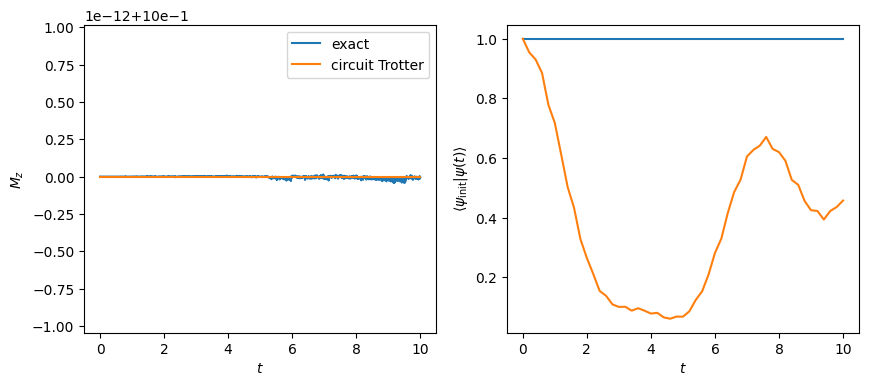

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
axs[0].plot(t_eval, exact_mag, label="exact")
axs[0].plot(t_eval_trotter, trotter_circ_mag, label="circuit Trotter")
axs[0].set_xlabel(rf"$t$")
axs[0].set_ylabel(rf"$M_z$")

axs[1].plot(t_eval, init_state_revival)
axs[1].plot(t_eval_trotter, trotter_circ_init_state_rev)
axs[1].set_xlabel(rf"$t$")
axs[1].set_ylabel(rf"$\langle \psi_{{\rm init}} | \psi(t) \rangle$")

axs[0].legend()

plt.show()